#### Initial data tidying

In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel('../Data/Rel_2_Nutrient_file.xlsx', sheet_name='All solids & liquids per 100g')

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

print("Dataset shape: {}".format(df.shape))
print("Non-numeric Features: {}".format(non_numeric_cols))
print("Number of numeric features: {}".format(len(numeric_cols)))

Dataset shape: (1616, 293)
Non-numeric Features: ['Public Food Key' 'Food Name']
Number of numeric features: 291


In [3]:
import numpy as np

cols_to_drop = []

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if pct_missing > 0.1:
        cols_to_drop.append(col)

# Remove columns and drop any NaN observations
df_clean = df.drop(cols_to_drop, axis=1)
df_clean = df_clean.dropna()

# First three features not useful in modelling so drop them too ('Public food key', 'Classification' and 'Food Name'))
df_clean = df_clean.iloc[:, 3:]

# Replace newline characters with a space
df_clean.columns = df_clean.columns.str.replace('\n', ' ')

print(df.shape)
print(df_clean.shape)

(1616, 293)
(1614, 60)


In [53]:
print("Observations with cholesterol: ", len(df_clean.loc[df_clean['Cholesterol  (mg)'] > 0]))
print("Observations without cholesterol: ", len(df_clean.loc[df_clean['Cholesterol  (mg)'] <= 0]))

# Create our data set for modelling
data_y = np.where(df_clean['Cholesterol  (mg)'] > 0, 1, 0)
data_x = df_clean.drop('Cholesterol  (mg)', axis=1)

Observations with cholesterol:  802
Observations without cholesterol:  812


#### DATA NORMALISATION

In [54]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Normalise the data
data_x_df = data_x
data_x = preprocessing.StandardScaler().fit_transform(data_x)
data_x_df = pd.DataFrame(data_x, columns=data_x_df.columns)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.7, shuffle=True, random_state=100)

#### DECISION TREE

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

# Hyperparameters
max_depths = np.arange(1, 15)
max_features = np.arange(1, data_x.shape[1])
accuracy_scores_depth = []
accuracy_scores_features = []

for i in max_depths:
    tree_model = DecisionTreeClassifier(max_depth=i,random_state=0).fit(X_train, y_train)
    tree_pred = tree_model.predict(X_test)
    accuracy_scores_depth.append(accuracy_score(y_test, tree_pred))

for i in max_features:
    tree_model = DecisionTreeClassifier(max_features=i,random_state=0).fit(X_train, y_train)
    tree_pred = tree_model.predict(X_test)
    accuracy_scores_features.append(accuracy_score(y_test, tree_pred))

#print("Tree Accuracy score: ", accuracy_score(y_test, tree_pred))


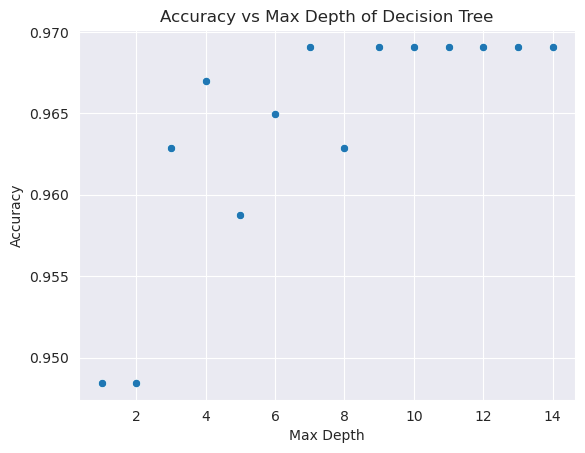

In [27]:
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

s1 = pd.DataFrame({'Max Depth' : max_depths, 'Accuracy': accuracy_scores_depth})
sns.scatterplot(data=s1, x='Max Depth', y='Accuracy', )
plt.title('Accuracy vs Max Depth of Decision Tree')
plt.savefig('../Report/Figures/max_depth.png')

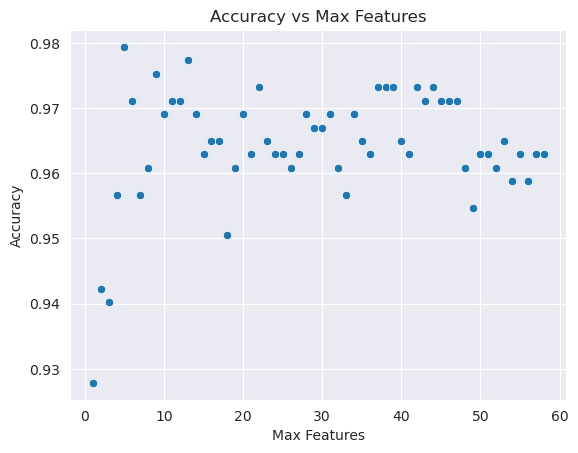

In [28]:
s2 = pd.DataFrame({'Max Features' : max_features, 'Accuracy': accuracy_scores_features})
sns.scatterplot(data=s2, x='Max Features', y='Accuracy')
plt.title('Accuracy vs Max Features')
plt.savefig('../Report/Figures/max_features.png')

##### Hyperparameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion':  ['gini', 'entropy'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'splitter': ['best', 'random']
}

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.4, 'splitter': 'best'}


In [30]:
from sklearn.metrics import accuracy_score

tree_model = DecisionTreeClassifier(random_state=0, max_depth=None, criterion='entropy', max_features=0.4, splitter='best').fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

print("Accuracy Score of refined decision tree: ", accuracy_score(tree_pred, y_test))

Accuracy Score of refined decision tree:  0.9649484536082474


/tmp/ipykernel_4821/3174711342.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


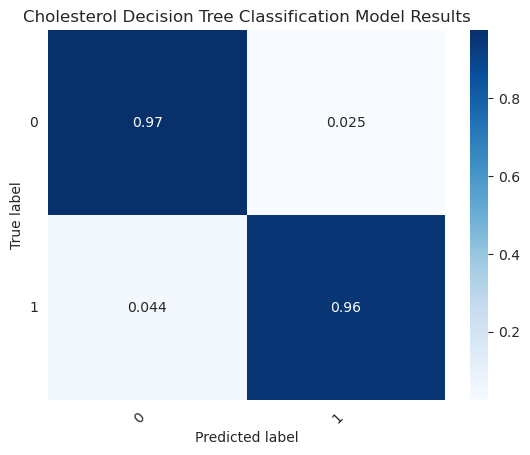

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conmat = confusion_matrix(y_test, tree_pred)

val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )

df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]  

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Cholesterol Decision Tree Classification Model Results')

plt.savefig('../Report/Figures/decision_tree_conmat.png')

#### K-NN MODEL

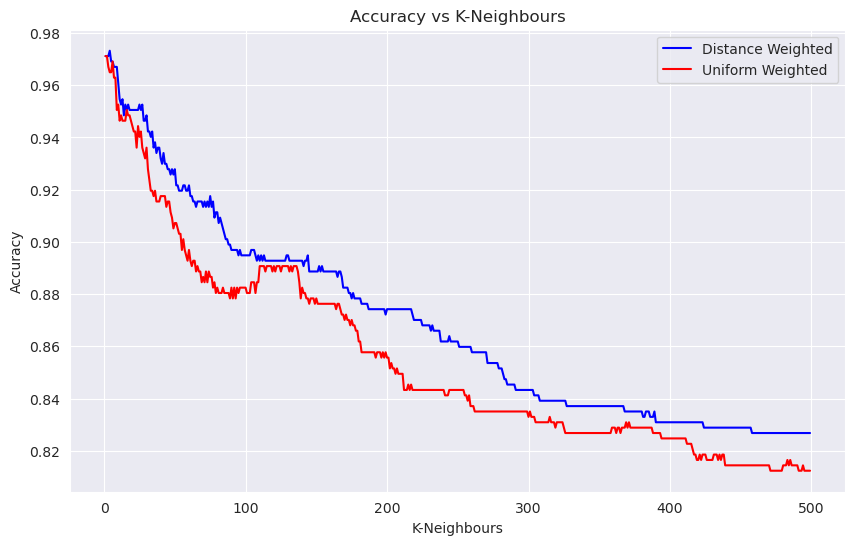

In [32]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

#knn_model_weights = ['uniform', 'distance']
knn_model_nneighbours = np.arange(1, 500)

#knn_uniform = []
#knn_distance = []
accuracy_scores_uniform = []
accuracy_scores_distance = []

for i in knn_model_nneighbours:

    knn_model = KNeighborsClassifier(n_neighbors=i, weights='distance').fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    accuracy_scores_distance.append(accuracy_score(y_test, knn_pred))
    
    knn_model = KNeighborsClassifier(n_neighbors=i, weights='uniform').fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    accuracy_scores_uniform.append(accuracy_score(y_test, knn_pred))



sns.set_style('darkgrid')


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(knn_model_nneighbours, accuracy_scores_distance, label='Distance Weighted', color='blue')
ax.plot(knn_model_nneighbours, accuracy_scores_uniform, label='Uniform Weighted', color='red')

ax.set_title('Accuracy vs K-Neighbours')
ax.set_xlabel('K-Neighbours')
ax.set_ylabel('Accuracy')
ax.legend()

plt.savefig('../Report/Figures/K-NN_params.png')

##### Hyperparamater Tuning

In [33]:
from sklearn.model_selection import GridSearchCV

params = {
    'weights':  ['uniform', 'distance'],
    'n_neighbors': np.arange(1, 500)
}

clf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    cv=5,
    n_jobs=5,
    verbose=1,
)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 998 candidates, totalling 4990 fits
{'n_neighbors': 3, 'weights': 'distance'}


In [34]:
knn_model = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print("Accuracy Score of tuned K-NN Classifier is ",accuracy_score(y_test, knn_pred))

Accuracy Score of tuned K-NN Classifier is  0.9711340206185567


/tmp/ipykernel_7636/2903922234.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


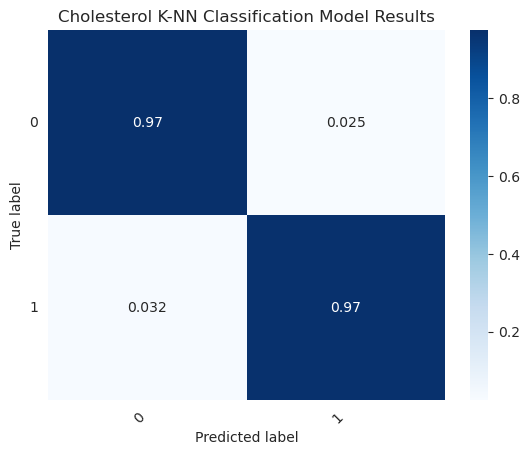

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conmat = confusion_matrix(y_test, knn_pred)

val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )

df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]  

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Cholesterol K-NN Classification Model Results')

plt.savefig('../Report/Figures/knn_conmat.png')

#### LOGISTIC MODEL

/home/peterlahanas/anaconda3/envs/comp4702/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/peterlahanas/anaconda3/envs/comp4702/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/peterlahanas/anaconda3/envs/comp4702/lib/python3.9/site-packages/sklearn/linear_model/_glm/_newton_solver.py:420: ConvergenceWarning: Newton solver did not converge after 1 iterations.
  warnings.warn(
/home/peterlahanas/anaconda3/envs/comp4702/lib/pyt

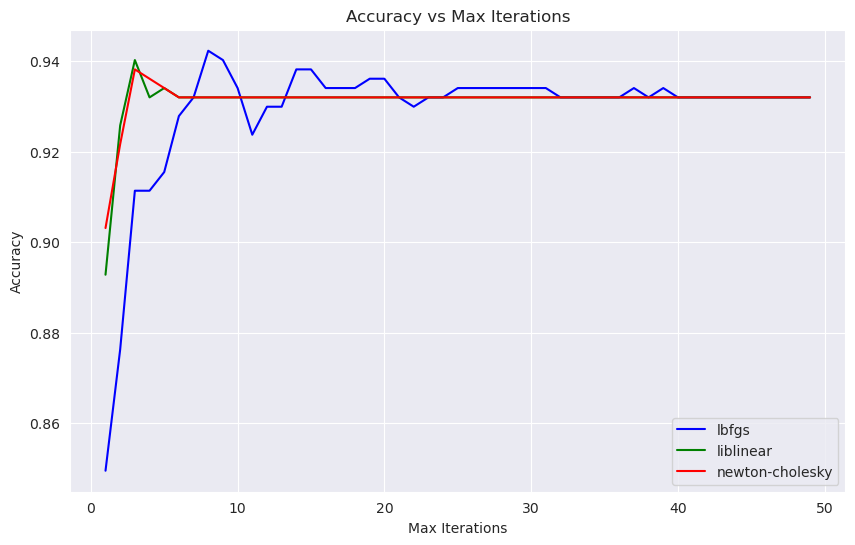

In [35]:
from sklearn.linear_model import LogisticRegression

max_iters = np.arange(1, 50)
accuracy_scores_lbfgs = []
accuracy_scores_liblinear = []
accuracy_scores_newton_cholesky = []

for i in max_iters:
    logistic_model = LogisticRegression(max_iter=i, solver='lbfgs').fit(X_train, y_train)
    logistic_pred = logistic_model.predict(X_test)
    accuracy_scores_lbfgs.append(accuracy_score(y_test, logistic_pred))

    logistic_model = LogisticRegression(max_iter=i, solver='liblinear').fit(X_train, y_train)
    logistic_pred = logistic_model.predict(X_test)
    accuracy_scores_liblinear.append(accuracy_score(y_test, logistic_pred))

    logistic_model = LogisticRegression(max_iter=i, solver='newton-cholesky').fit(X_train, y_train)
    logistic_pred = logistic_model.predict(X_test)
    accuracy_scores_newton_cholesky.append(accuracy_score(y_test, logistic_pred))



sns.set_style('darkgrid')


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(max_iters, accuracy_scores_lbfgs, label='lbfgs', color='blue')
ax.plot(max_iters, accuracy_scores_liblinear, label='liblinear', color='green')
ax.plot(max_iters, accuracy_scores_newton_cholesky, label='newton-cholesky', color='red')

ax.set_title('Accuracy vs Max Iterations')
ax.set_xlabel('Max Iterations')
ax.set_ylabel('Accuracy')
ax.legend()

plt.savefig('../Report/Figures/logistic_params.png')

In [36]:
logistic_model = LogisticRegression().fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
print("Logistic Regression Model accuracy score ", accuracy_score(y_test, logistic_pred))

Logistic Regression Model accuracy score  0.931958762886598


/tmp/ipykernel_7636/2805113029.py:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


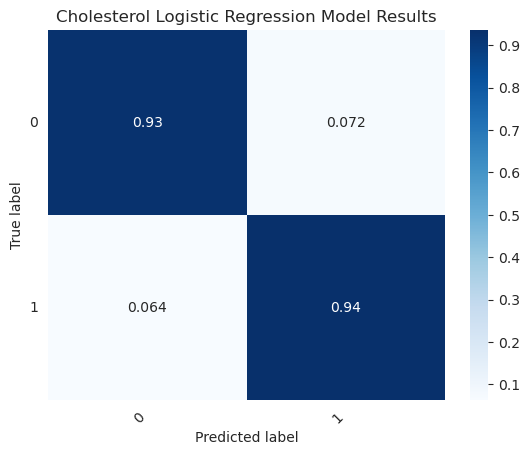

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conmat = confusion_matrix(y_test, logistic_pred)

val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )

df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]  

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Cholesterol Logistic Regression Model Results')

plt.savefig('../Report/Figures/logistic_conmat.png')

#### ENSEMBLE METHODS (Bagging and Boosting)

#### BAGGING

In [65]:
from sklearn.ensemble import BaggingClassifier

# DECISION TREE MODEL
bagged_tree_model = BaggingClassifier(random_state=0, estimator=tree_model).fit(X_train, y_train)
bagged_tree_model_pred = bagged_tree_model.predict(X_test)
print("Decision Tree E hold out % ", (1-accuracy_score(y_test, tree_pred)) * 100)
print("Bagged Decision Tree E hold out % ", (1-accuracy_score(y_test, bagged_tree_model_pred)) * 100)


# K-NN MODEL
bagged_knn_model = BaggingClassifier(random_state=0, estimator=knn_model).fit(X_train, y_train)
bagged_knn_model_pred = bagged_knn_model.predict(X_test)
print("K-NN Accuracy Score ", (1-accuracy_score(y_test, knn_pred))*100)
print("Bagged K-NN accuracy score ", (1-accuracy_score(y_test, bagged_knn_model_pred))*100)

# LOGISTIC REGRESSION MODEL
bagged_logistic_model = BaggingClassifier(random_state=0, estimator=logistic_model).fit(X_train, y_train)
bagged_logistic_model_pred = bagged_logistic_model.predict(X_test)
print("Logistic Accuracy Score ", (1-accuracy_score(y_test, logistic_pred))*100)
print("Bagged logistic model accuracy score ", (1-accuracy_score(y_test, bagged_logistic_model_pred))*100)

Decision Tree E hold out %  3.5051546391752564
Bagged Decision Tree E hold out %  2.268041237113405
K-NN Accuracy Score  2.8865979381443307
Bagged K-NN accuracy score  3.5051546391752564
Logistic Accuracy Score  6.804123711340204
Bagged logistic model accuracy score  6.391752577319587


#### BOOSTING

In [79]:
from sklearn.ensemble import AdaBoostClassifier

# DECISION TREE MODEL

boosted_tree_model = AdaBoostClassifier(random_state=0, estimator=tree_model).fit(X_train, y_train)
boosted_tree_model_pred = boosted_tree_model.predict(X_test)
print("Decision Tree E hold out % ", (1-accuracy_score(y_test, tree_pred)) * 100)
print("Boosted Decision Tree E hold out % ", (1-accuracy_score(y_test, boosted_tree_model_pred)) * 100)


# K-NN MODEL
# boosted_knn_model = AdaBoostClassifier(random_state=0, estimator=knn_model).fit(X_train, y_train)
# boosted_knn_model_pred = boosted_knn_model.predict(X_test)
# print("K-NN Accuracy Score ", (1-accuracy_score(y_test, knn_pred))*100)
# print("Boosted K-NN accuracy score ", (1-accuracy_score(y_test, boosted_knn_model_pred))*100)

# LOGISTIC REGRESSION MODEL
boosted_logistic_model = AdaBoostClassifier(random_state=0, estimator=logistic_model).fit(X_train, y_train)
boosted_logistic_model_pred = boosted_logistic_model.predict(X_test)
print("Logistic Accuracy Score ", (1-accuracy_score(y_test, logistic_pred))*100)
print("Boosted logistic model accuracy score ", (1-accuracy_score(y_test, boosted_logistic_model_pred))*100)

Decision Tree E hold out %  3.5051546391752564
Boosted Decision Tree E hold out %  4.32989690721649
Logistic Accuracy Score  6.804123711340204
Boosted logistic model accuracy score  7.628865979381438


#### ENSEMBLE METHODS SUMMARY

In [92]:
weak_tree_1 = DecisionTreeClassifier(random_state=0, max_depth=1).fit(X_train, y_train)
weak_tree_3 = DecisionTreeClassifier(random_state=0, max_depth=3).fit(X_train, y_train)


e_hold_outs_1_boost = []
e_hold_outs_3_boost = []
e_hold_outs_1_bag = []
e_hold_outs_3_bag = []
n = np.arange(1, 100)

for i in n:
    boosted_weak_tree_1 = AdaBoostClassifier(random_state=0, estimator=weak_tree_1, n_estimators=i, learning_rate=0.1).fit(X_train, y_train)
    boosted_weak_tree_3 = AdaBoostClassifier(random_state=0, estimator=weak_tree_3, n_estimators=i, learning_rate=0.1).fit(X_train, y_train)
    boosted_weak_tree_1_pred = boosted_weak_tree_1.predict(X_test)
    boosted_weak_tree_3_pred = boosted_weak_tree_3.predict(X_test)

    bagged_weak_tree_1 = BaggingClassifier(random_state=0, estimator=weak_tree_1, n_estimators=i).fit(X_train, y_train)
    bagged_weak_tree_3 = BaggingClassifier(random_state=0, estimator=weak_tree_3, n_estimators=i).fit(X_train, y_train)
    bagged_weak_tree_1_pred = bagged_weak_tree_1.predict(X_test)
    bagged_weak_tree_3_pred = bagged_weak_tree_3.predict(X_test)
    
    e_hold_outs_1_boost.append(1-accuracy_score(y_test, boosted_weak_tree_1_pred))
    e_hold_outs_3_boost.append(1-accuracy_score(y_test, boosted_weak_tree_3_pred))
    e_hold_outs_1_bag.append(1-accuracy_score(y_test, bagged_weak_tree_1_pred))
    e_hold_outs_3_bag.append(1-accuracy_score(y_test, bagged_weak_tree_3_pred))



#print("Weak Decision Tree E hold out % ", (1-accuracy_score(y_test, weak_tree_preds)) * 100)
#print("Boosted Weak Decision Tree E hold out % ", (1-accuracy_score(y_test, boosted_weak_tree_pred)) * 100)

#### MULTI-THREADED?

In [103]:
import concurrent.futures

weak_tree_1 = DecisionTreeClassifier(random_state=0, max_depth=1).fit(X_train, y_train)
weak_tree_3 = DecisionTreeClassifier(random_state=0, max_depth=3).fit(X_train, y_train)

e_hold_outs_1_boost = []
e_hold_outs_3_boost = []
e_hold_outs_1_bag = []
e_hold_outs_3_bag = []
n = np.arange(1, 100)

def run_estimators(i):
    boosted_weak_tree_1 = AdaBoostClassifier(random_state=0, estimator=weak_tree_1, n_estimators=i, learning_rate=0.5).fit(X_train, y_train)
    boosted_weak_tree_3 = AdaBoostClassifier(random_state=0, estimator=weak_tree_3, n_estimators=i, learning_rate=0.5).fit(X_train, y_train)
    boosted_weak_tree_1_pred = boosted_weak_tree_1.predict(X_test)
    boosted_weak_tree_3_pred = boosted_weak_tree_3.predict(X_test)

    bagged_weak_tree_1 = BaggingClassifier(random_state=0, estimator=weak_tree_1, n_estimators=i).fit(X_train, y_train)
    bagged_weak_tree_3 = BaggingClassifier(random_state=0, estimator=weak_tree_3, n_estimators=i).fit(X_train, y_train)
    bagged_weak_tree_1_pred = bagged_weak_tree_1.predict(X_test)
    bagged_weak_tree_3_pred = bagged_weak_tree_3.predict(X_test)

    return (1-accuracy_score(y_test, boosted_weak_tree_1_pred)), (1-accuracy_score(y_test, boosted_weak_tree_3_pred)), (1-accuracy_score(y_test, bagged_weak_tree_1_pred)), (1-accuracy_score(y_test, bagged_weak_tree_3_pred))

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    results = executor.map(run_estimators, n)

for res in results:
    e_hold_outs_1_boost.append(res[0])
    e_hold_outs_3_boost.append(res[1])
    e_hold_outs_1_bag.append(res[2])
    e_hold_outs_3_bag.append(res[3])


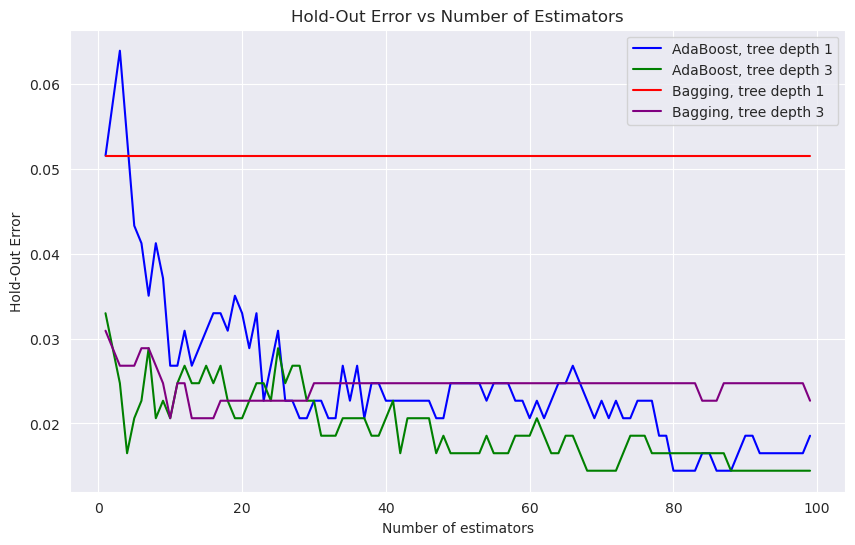

In [106]:
sns.set_style('darkgrid')


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(n, e_hold_outs_1_boost, label='AdaBoost, tree depth 1', color='blue')
ax.plot(n, e_hold_outs_3_boost, label='AdaBoost, tree depth 3', color='green')
ax.plot(n, e_hold_outs_1_bag, label='Bagging, tree depth 1', color='red')
ax.plot(n, e_hold_outs_3_bag, label='Bagging, tree depth 3', color='purple')

ax.set_title('Hold-Out Error vs Number of Estimators')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Hold-Out Error')
ax.legend()
plt.savefig('../Report/Figures/tree_depth_ensemble.png')

#### NN

In [101]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#%load_ext tensorboard

# !rm -rf ./logs/ 
# print(tf.__version__)

tf.random.set_seed(0)
np.random.seed(0)

# define the model architecture
model = keras.Sequential([
    layers.Dense(59, activation='relu', input_dim=X_train.shape[1]),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 59)                3540      
                                                                 
 dense_75 (Dense)            (None, 32)                1920      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 dense_76 (Dense)            (None, 16)                528       
                                                                 
 dropout_29 (Dropout)        (None, 16)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,005
Trainable params: 6,005
Non-train

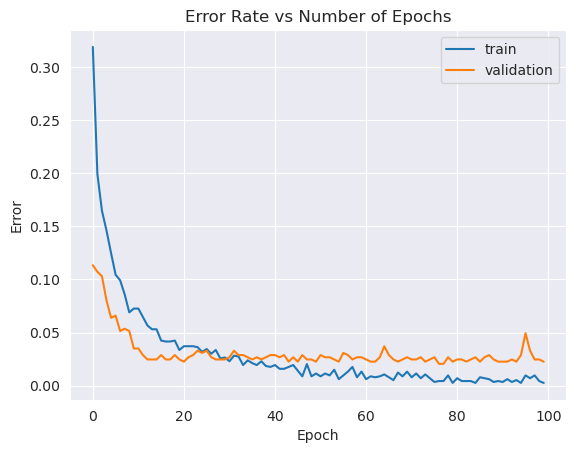

In [99]:
import matplotlib.pyplot as plt


def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = 1- np.array(training_result.history[str(metric)])
	validation_perf = 1- np.array(training_result.history['val_'+str(metric)])
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
    
	plt.plot(train_perf, label="train")
	plt.plot(validation_perf, label = 'validation')

            	 
	plt.xlabel('Epoch')
	plt.ylabel("Error")
	plt.legend(loc='upper right')
	plt.title("Error Rate vs Number of Epochs")

show_performance_curve(history, 'accuracy', 'error')
plt.savefig("../Report/Figures/nn-epochs.png")

#%tensorboard --logdir logs/fit

16/16 [==============================] - 0s 2ms/step


/tmp/ipykernel_4821/2695843996.py:18: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


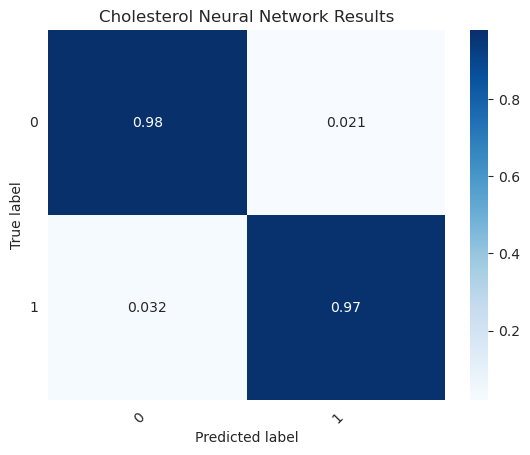

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_predictions = np.round(model.predict(X_test))

conmat = confusion_matrix(y_test, test_predictions)

val = np.mat(conmat) 

classnames = list(set(y_train))

df_cm = pd.DataFrame(

        val, index=classnames, columns=classnames, 

    )

df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]  

plt.figure()

heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.title('Cholesterol Neural Network Results')
plt.savefig("../Report/Figures/nn-conf.png")

#### NOTES
- Do each model separately and graph the effects of tuning with different hyperparameters
- For Decision Tree, try increasing depth etc.

Let's try to estimate variance and bias for our models here????

- Logistic probably not too much variance so try boosting to reduce bias??
- Tree model high variance, let's reduce with bagging?
- Try a Random Forest Classifier?